# Structural Estimation of Market Parameters

### Sequential Estimator

In [1]:
using Pkg
Pkg.activate(".")
#for pkg in ["BlackBoxOptim", "Cubature", "Distributions", "Integrals", "Roots", "PythonPlot", "PrettyTables", "JLD", "StatProfilerHTML"] # 
#    Pkg.add(pkg)
#end

Pkg.instantiate()

using BlackBoxOptim, Cubature, Distributions, Integrals, Random, Roots, PythonPlot, PrettyTables, JLD

  Activating project at `C:\Users\jbrig\Documents\research\mapinator_2024\notes\estimation_of_tau`
    CondaPkg Found dependencies: C:\Users\jbrig\.julia\packages\PythonCall\Nr75f\CondaPkg.toml
    CondaPkg Found dependencies: C:\Users\jbrig\.julia\packages\PythonPlot\469aA\CondaPkg.toml
    CondaPkg Dependencies already up to date


## 1. Load placements

In [2]:
placement_matrices = load("placement_matrices.jld")

Dict{String, Any} with 4 entries:
  "successful_tier_1_range" => 2018:2023
  "placement_matrix"        => [761 115 … 8 0; 879 569 … 48 4; … ; 165 244 … 20…
  "successful_tier_1"       => 2098
  "unmatched"               => [300, 544, 667, 364, 273]

In [3]:
placement_rates_raw = placement_matrices["placement_matrix"]

10×5 Matrix{Int64}:
 761  115   41    8    0
 879  569  148   48    4
 839  993  443   60   14
 176  306  217  140   11
   3   14   16   15   46
 582  596  301   79   19
 700  438  244   68   24
 218  187  114   39    9
 165  244  315  201  104
 676  967  815  309  123

In [4]:
unmatched_raw = placement_matrices["unmatched"]

5-element Vector{Int64}:
 300
 544
 667
 364
 273

In [5]:
k = size(placement_rates_raw)[2]
K = size(placement_rates_raw)[1]

10

## 2. Rescale placements (successes and failures) using registrations

In [6]:
# conduct adjustment using the relative m_t values
adjustment_matrix = load("adjustment_matrix.jld")
m_t_values = adjustment_matrix["data"][:, 1]

5-element Vector{Any}:
 2664
 3635
 4481
 2284
 1347

In [7]:
m_t_placements = zeros(Int, k)
for t in 1:k
    m_t_placements[t] = sum(placement_rates_raw[:, t]) + unmatched_raw[t]
end
m_t_placements

5-element Vector{Int64}:
 5299
 4973
 3321
 1331
  627

In [8]:
placement_rates_rescaled = zeros(Int, K, k)
unmatched_rescaled = zeros(Int, k)

for i in 1:K
    for t in 1:k
        placement_rates_rescaled[i, t] = round(m_t_values[t] * (placement_rates_raw[i, t] / m_t_placements[t]))
    end
end

for t in 1:k
    unmatched_rescaled[t] = round(m_t_values[t] * (unmatched_raw[t] / m_t_placements[t]))
end

placement_rates_rescaled

10×5 Matrix{Int64}:
 383   84    55   14    0
 442  416   200   82    9
 422  726   598  103   30
  88  224   293  240   24
   2   10    22   26   99
 293  436   406  136   41
 352  320   329  117   52
 110  137   154   67   19
  83  178   425  345  223
 340  707  1100  530  264

In [9]:
unmatched_rescaled

5-element Vector{Int64}:
 151
 398
 900
 625
 586

## 3. Collapse sinks and delete graduating tier 5 (tier 5 becomes part of the sinks)

In [10]:
println("original dimensions: ", K, " by ", k)

original dimensions: 10 by 5


In [11]:
k -= 1
K = k + 3

7

In [12]:
println("new dimensions: ", K, " by ", k)

new dimensions: 7 by 4


In [13]:
placement_rates = zeros(Int, K, k)
for i in 1:4 # NOTE: hardcoded
    for t in 1:k
        placement_rates[i, t] = placement_rates_rescaled[i, t]
    end
end

for i in 5:6 # NOTE: hardcoded
    for t in 1:k
        placement_rates[i, t] = placement_rates_rescaled[i+1, t]
    end
end

for t in 1:k
    # NOTE: hardcoded
    for original_sink_tier in [5, 8, 9, 10]
        placement_rates[K, t] += placement_rates_rescaled[original_sink_tier, t] 
    end
end

unmatched = zeros(Int, k)
for t in 1:k
    unmatched[t] = unmatched_rescaled[t]
end

placement_rates

7×4 Matrix{Int64}:
 383    84    55   14
 442   416   200   82
 422   726   598  103
  88   224   293  240
 293   436   406  136
 352   320   329  117
 535  1032  1701  968

In [14]:
unmatched

4-element Vector{Int64}:
 151
 398
 900
 625

## 3a. Latex version of the new table

In [15]:
presentation_table = zeros(Int, K+1, k)
for i in 1:K, t in 1:k
    presentation_table[i, t] = placement_rates[i, t]
end

for t in 1:k
    presentation_table[K+1, t] = unmatched[t]
end

In [16]:
include("type_allocation_base_by_applicant.jl")

Main.SBM

In [17]:
presentation_table

8×4 Matrix{Int64}:
 383    84    55   14
 442   416   200   82
 422   726   598  103
  88   224   293  240
 293   436   406  136
 352   320   329  117
 535  1032  1701  968
 151   398   900  625

In [18]:
sink_names_to_present = [
    "Public Sector",
    "Private Sector",
    "Other",
    "Unmatched"
]
SBM.nice_table(presentation_table, k, (K - k) + 1, sink_names_to_present)

┌────────────────┬────────┬────────┬────────┬────────┬────────────┐
│                │ Tier 1 │ Tier 2 │ Tier 3 │ Tier 4 │ Row Totals │
├────────────────┼────────┼────────┼────────┼────────┼────────────┤
│         Tier 1 │    383 │     84 │     55 │     14 │        536 │
│         Tier 2 │    442 │    416 │    200 │     82 │       1140 │
│         Tier 3 │    422 │    726 │    598 │    103 │       1849 │
│         Tier 4 │     88 │    224 │    293 │    240 │        845 │
│  Public Sector │    293 │    436 │    406 │    136 │       1271 │
│ Private Sector │    352 │    320 │    329 │    117 │       1118 │
│          Other │    535 │   1032 │   1701 │    968 │       4236 │
│      Unmatched │    151 │    398 │    900 │    625 │       2074 │
│  Column Totals │   2666 │   3636 │   4482 │   2285 │      13069 │
└────────────────┴────────┴────────┴────────┴────────┴────────────┘
\begin{tabular}{rrrrrr}
  \hline
   & \textbf{Tier 1} & \textbf{Tier 2} & \textbf{Tier 3} & \textbf{Tier 4} & \textb

## 4. Compute $m$ and $\gamma_t$

In [19]:
res = (; placements = placement_rates) 

M = sum(res.placements)

successful_graduates = [sum(res.placements[:, t]) for t in 1:k]
println("successful graduates: ", M)
println(successful_graduates)
println()

estimated_m_val = sum(m_t_values)

successful graduates: 10995
[2515, 3238, 3582, 1660]



14411

In [20]:
estimated_γ = m_t_values / estimated_m_val

5-element Vector{Float64}:
 0.1848587884255083
 0.25223787384636737
 0.31094302963014364
 0.15849004232877664
 0.09347026576920409

## 5. Estimate $\frac{v_{t+1}}{v_t}$ and $\tau$ simultaneously

In [21]:
# define p_vec as e.g.
# [v2/v1 v3/v2 v4/v3 α1 α2 α3 α4 mu1 mu2 mu3 mu4 mus sg1 sg2 sg3 sg4 sgs]

function q_prob(t, v_rel, mkt_balance_ratio, gamma, k)
    numerator = prod([v_rel[s] for s in t:k-1])
    denominator = exp(1 / mkt_balance_ratio) * prod([((v_rel[s])^(sum(gamma[1:s]))) for s in 1:k-1])
    return numerator / denominator
end

function F(x, ρ, normals, K)
    sum_base = 0.0
    for i in 1:K
        sum_base += ρ[i] * cdf(normals[i], x)
    end
    return sum_base
end

function f_integrand(integrals, x, p) 
    base_exp = exp(F(x, p.ρ, p.normals, p.K) / sum(p.α[1:p.s]))
    for i in 1:p.K
        integrals[i] = base_exp * pdf(p.normals[i], x)
    end
end

function get_integrals(x_vec, ρ, normals, α, k, K)
    # Fx_vec = [F(x0)=1, F(x1), F(x2), F(x3), ..., F(xk-1)]
    # x_vec = [x0 = 1, x1, x2, x3, ..., xk = 0]
    # x_vec[s] = x_{s-1}, so the limits of integration are and must be offset by 1 below
    all_integrals = zeros(K, k)
    for s in 1:k
        # https://docs.sciml.ai/Integrals/stable/basics/SampledIntegralProblem/ might be faster
        # if f_integrand(x) can be vectorized/sped up
        prob = IntegralProblem(IntegralFunction(f_integrand, zeros(K)), (x_vec[s+1], x_vec[s]), (; s, ρ, normals, α, K))
        sol = solve(prob, CubatureJLh(); reltol = 1e-3, abstol = 1e-3)
        integrals_result = sol.u
        # NOTE: result may be inf if alpha_1 is too small
        # NOTE: some parameter values for μ and σ may cause the cdf F_i to be NaN
        for i in 1:K 
            all_integrals[i, s] = integrals_result[i]
        end
    end
    return all_integrals
end      

function q(i, t, all_integrals, Fx_vec, α, v_rel, k)
    return α[t] * sum([(1/sum(α[1:s])) * prod([v_rel[j] for j in t:(s-1)]) * exp(-Fx_vec[s] / sum(α[1:s])) * all_integrals[i, s] for s in t:k])
end

function Fx(t, α, v_rel)
    return 1 - sum([-log(v_rel[j])*sum(α[1:j]) for j in 1:t])
end

function pi(t, α)
    return α[t] / sum(α[1:t])
end

function ρ_q(t, α, v_rel, k)
    Fx_km1 = Fx(k-1, α, v_rel)
    if Fx_km1 <= 0
        return -1
    end
    last_term = prod([v_rel[j] for j in t:(k-1)]) * (1 - exp((0 - Fx_km1) / sum(α[1:k])))
    return α[t] * (sum([prod([v_rel[j] for j in t:(s-1)]) * (1 - v_rel[s]) for s in t:(k-1)]) + last_term)
end

ρ_q (generic function with 1 method)

In [22]:
function estimate_parameters_stage_1(p_vec, placements, γ, m_val, k)
    v_rel = p_vec[1:k-1]
    τ = p_vec[k]
    α = τ * γ

    n_val = (m_val / τ) + 1

    objective = 0.0

    ρ_q_t = zeros(k)
    for t in 1:k
        prob = ρ_q(t, α, v_rel, k)
        if prob < 0
            return Inf
        end
        ρ_q_t[t] = prob
    end

    for t in 1:k
        prob = ρ_q_t[t]
        expectation = n_val * prob
        objective += ((sum(placements[:, t]) - expectation) ^ 2) / expectation
    end
    
    return objective
end

estimate_parameters_stage_1 (generic function with 1 method)

In [23]:
Random.seed!(0)

# upper/lower bound on v_rel
upper_1 = [1.0 for _ in 1:k-1]
lower_1 = [0.0 for _ in 1:k-1]

# upper/lower bound on τ
append!(upper_1, [10.0 for _ in 1:1])
append!(lower_1, [0.25 for _ in 1:1])

search_range_1 = [(lower_1[i], upper_1[i]) for i in eachindex(upper_1)]
sol_res_1 = bboptimize(p -> estimate_parameters_stage_1(p, res.placements, estimated_γ, estimated_m_val, k), SearchRange = search_range_1, MaxFuncEvals = 1000000, TraceInterval = 5) 
# MaxTime = 60.0, MaxFuncEvals = 500000,
sol_1 = best_candidate(sol_res_1)

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps

Optimization stopped after 1099017 steps and 1.82 seconds
Termination reason: Max number of function evaluations (1000000) reached
Steps per second = 602531.21
Function evals per second = 548246.13
Improvements/step = Inf
Total function evaluations = 1000001


Best candidate found: [0.512286, 0.544467, 0.734376, 0.556643]

Fitness: 0.000000000



4-element Vector{Float64}:
 0.5122856729316837
 0.5444666789677739
 0.7343759862308326
 0.5566428717441424

In [24]:
estimated_v_rel = sol_1[1:k-1]
estimated_τ = sol_1[k]

0.5566428717441424

In [25]:
println("estimated value ratios:")
display(estimated_v_rel)
println()
estimated_v_base = 1
for i in 1:k
    println("v", i, ": ", estimated_v_base)
    if i != k
        estimated_v_base = estimated_v_rel[i] * estimated_v_base
    end
end
println()

println("estimated market balance ratio (m / (n-1)): ", estimated_τ)

estimated_n_val = (estimated_m_val / estimated_τ) + 1
println("estimated total departments: ", estimated_n_val)
estimated_α = estimated_τ * estimated_γ
println("estimated α_t: ", estimated_α)

estimated value ratios:


3-element Vector{Float64}:
 0.5122856729316837
 0.5444666789677739
 0.7343759862308326


v1: 1
v2: 0.5122856729316837
v3: 0.27892247902388506
v4: 0.2048339706151143

estimated market balance ratio (m / (n-1)): 0.5566428717441424
estimated total departments: 25890.130592556892
estimated α_t: [0.10290032685631777, 0.14040641446047863, 0.17308422096214712, 0.08822235230474092, 0.05202955716045797]


## 6. Estimate $\rho_i$, $\mu_i$ and $\sigma_i$

In [26]:
function estimate_likelihood_2(p_vec, v_rel, α, placements, k, K, counter)   
    μ = p_vec[1:K]
    σ = p_vec[K+1:2K]
    ρ_vec = p_vec[2K+1:3K]
    ρ = ρ_vec / sum(ρ_vec)

    ## compute the cutoffs x and the CDF values F(x)
    normals = [truncated(Normal(μ[i], σ[i]), 0, 1) for i in 1:K]

    Fx_vec = ones(k) # sets F(x0) = 1 by default; Fx_vec = [F(x0)=1, F(x1), F(x2), F(x3), ..., F(xk-1)]
    x_vec = ones(k+1) # x_vec = [x0 = 1, x1, x2, x3, ..., xk = 0]
    x_vec[k+1] = 0.0
    for t in 1:k-1
        Fx_vec_candidate = Fx(t, α, v_rel)
        if Fx_vec_candidate <= 0.0 # TODO: if this case occurs, can we speed up q()?
            Fx_vec[t+1:k] .= 0.0
            x_vec[t+1:k] .= 0.0
            break
        end
        Fx_vec[t+1] = Fx_vec_candidate
        # there is no simple closed-form for F^{-1}(x) so this numerically computes x1, x2, x3
        x_vec[t+1] = find_zero(x -> F(x, ρ, normals, K) - Fx_vec[t+1], 0.5) 
    end 

    ρ_q_it = zeros(K, k)
    all_integrals = get_integrals(x_vec, ρ, normals, α, k, K)
    for i in 1:K, t in 1:k
        prob = q(i, t, all_integrals, Fx_vec, α, v_rel, k)
        ρ_q_it[i, t] = ρ[i] * prob
    end

    normalizer = sum(ρ_q_it)
    likelihood = 0.0
    for i in 1:K, t in 1:k
        likelihood += placements[i, t] * log(ρ_q_it[i, t] / normalizer)
    end

    counter[1] += 1
    if isnan(-likelihood) || isinf(-likelihood)
        println(all_integrals)
    end
    return -likelihood
end

estimate_likelihood_2 (generic function with 1 method)

In [27]:
Random.seed!(0)

# upper/lower bound on the mu parameter of truncated normal
upper_2 = [4.0 for _ in 1:K]
lower_2 = [-4.0 for _ in 1:K]

# upper/lower bound on the sigma parameter of truncated normal
append!(upper_2, [10.0 for _ in 1:K])
append!(lower_2, [0.12 for _ in 1:K])

# upper/lower bound on values proportional to ρ_i
append!(upper_2, [1.0 for _ in 1:K])
append!(lower_2, [0.0 for _ in 1:K])

counter = [0]

search_range_2 = [(lower_2[i], upper_2[i]) for i in eachindex(upper_2)]
sol_res_2 = bboptimize(p -> estimate_likelihood_2(p, estimated_v_rel, estimated_α, res.placements, k, K, counter), SearchRange = search_range_2, MaxFuncEvals = 100000, TraceInterval = 5) 
# MaxTime = 60.0, MaxFuncEvals = 500000,
sol_2 = best_candidate(sol_res_2)

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
5.00 secs, 76932 evals, 76848 steps, improv/step: 0.152 (last = 0.1520), fitness=32958.020164765

Optimization stopped after 99920 steps and 6.46 seconds
Termination reason: Max number of function evaluations (100000) reached
Steps per second = 15474.68
Function evals per second = 15487.22
Improvements/step = Inf
Total function evaluations = 100001


Best candidate found: [2.48187, 0.476956, 0.429753, -3.75801, 0.358705, 0.259537, -1.9431, 1.12772, 0.204324, 0.129073, 0.781558, 0.193066, 0.317809, 0.626995, 0.0598635, 0.150327, 0.253075, 0.201793, 0.189327, 0.171214, 0.951925]

Fitness: 32957.641938295



21-element Vector{Float64}:
  2.4818710527218975
  0.4769560887214227
  0.42975270854979014
 -3.7580123862225494
  0.3587047301872907
  0.25953737991481907
 -1.9430982461295008
  1.127724685979468
  0.20432380588551424
  0.12907254182249672
  0.7815575056380789
  0.19306584290756887
  0.31780910716226135
  0.6269948878326131
  0.05986349312906927
  0.15032694156861626
  0.25307530916916493
  0.20179295993429938
  0.18932745094154657
  0.17121354984965304
  0.9519247758700972

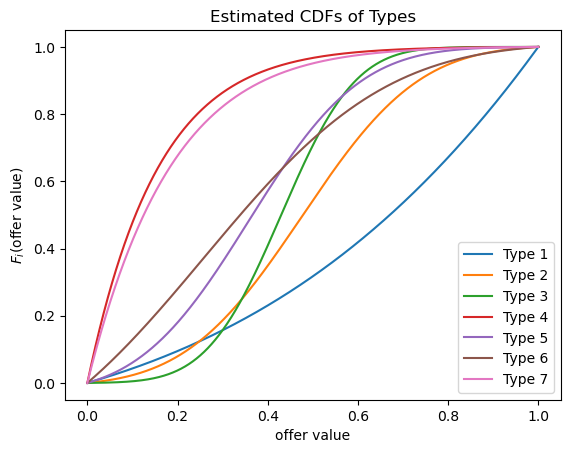

In [28]:
point_grid = [i for i in range(0, 1; length = 10001)]
for select_type in 1:K
    plot(point_grid, [cdf(truncated(Normal(sol_2[select_type], sol_2[select_type+K]), 0, 1), x) for x in point_grid], label = string("Type ", select_type))
end

title("Estimated CDFs of Types")
xlabel("offer value")
ylabel("\$F_i\$(offer value\$)\$")
legend();

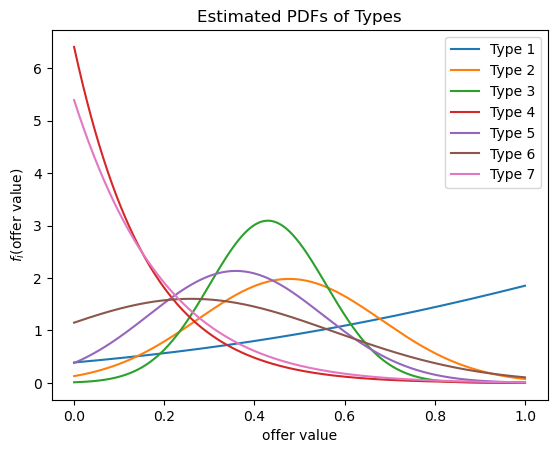

In [29]:
for select_type in 1:K
    plot(point_grid, [pdf(truncated(Normal(sol_2[select_type], sol_2[select_type+K]), 0, 1), x) for x in point_grid], label = string("Type ", select_type))
end
title("Estimated PDFs of Types")
xlabel("offer value")
ylabel("\$f_i\$(offer value\$)\$")
legend();

In [30]:
for select_type in 1:K
    println("Type $(select_type):")
    println("  est. mean:   ", mean(truncated(Normal(sol_2[select_type], sol_2[select_type+K]), 0, 1)))
    println("  est. stddev: ", std(truncated(Normal(sol_2[select_type], sol_2[select_type+K]), 0, 1)))
    println()
end

Type 1:
  est. mean:   0.6218731109376237
  est. stddev: 0.26941936271681677

Type 2:
  est. mean:   0.47925817202255716
  est. stddev: 0.1937007212849477

Type 3:
  est. mean:   0.4299514174743576
  est. stddev: 0.12872960530650412

Type 4:
  est. mean:   0.15008981318397652
  est. stddev: 0.14350323051369798

Type 5:
  est. mean:   0.3725486190702214
  est. stddev: 0.17831734889909354

Type 6:
  est. mean:   0.36481522548131606
  est. stddev: 0.2277440317418155

Type 7:
  est. mean:   0.1719001720496114
  est. stddev: 0.15910837225118346



In [31]:
function print_metrics(p_vec, v_rel, gamma, mkt_balance_ratio, placements, k, K, M, m_val)
    α = mkt_balance_ratio * gamma
    n_val = (m_val / mkt_balance_ratio) + 1
    
    μ = p_vec[1:K]
    σ = p_vec[K+1:2K]
    ρ_vec = p_vec[2K+1:3K]
    ρ = ρ_vec / sum(ρ_vec)
    normals = [truncated(Normal(μ[i], σ[i]), 0, 1) for i in 1:K]
    
    n = n_val * ρ

    ρ_q_it_true = placements / n_val
    
    Fx_vec = ones(k)
    x_vec = ones(k+1)
    x_vec[k+1] = 0.0
    for t in 1:k-1
        Fx_vec_candidate = Fx(t, α, v_rel)
        if Fx_vec_candidate <= 0.0
            Fx_vec[t+1:k] .= 0.0
            x_vec[t+1:k] .= 0.0
            break
        end
        Fx_vec[t+1] = Fx_vec_candidate
        x_vec[t+1] = find_zero(x -> F(x, ρ, normals, K) - Fx_vec[t+1], 0.5) 
    end

    objective_chisquare = 0.0
    objective_likelihood = 0.0
    objective_likelihood_simple = 0.0
    normalizer = 0.0
    
    q_it = zeros(K, k)
    ρ_i_q_it = zeros(K, k)
    all_integrals = get_integrals(x_vec, ρ, normals, α, k, K)
    for i in 1:K, t in 1:k
        prob = q(i, t, all_integrals, Fx_vec, α, v_rel, k)
        q_it[i, t] = prob
        ρ_i_q_it[i, t] = ρ[i] * prob
        normalizer += ρ[i] * prob
    end

    round_1_failure = zeros(K)
    for i in 1:K
        round_1_failure[i] = (1 - sum([q_it[i, s] for s in 1:k]))
    end
    
    # TODO: div by zero and negative floating point in mean
    exp_placements = zeros(K, k)
    for i in 1:K, t in 1:k 
        expectation = M * ρ_i_q_it[i, t] / normalizer
        exp_placements[i, t] = expectation
        objective_chisquare += (placements[i, t] - expectation) ^ 2 / expectation
        objective_likelihood_simple += placements[i, t] * log(ρ_i_q_it[i, t] / normalizer)
    end 

    println("chi-square objective value (successful placements) = ", objective_chisquare)

    likelihood_probability_vector = zeros(k * K)
    total_placements_vector = zeros(k * K)
    vector_counter = 1
    for i in 1:K
        for t in 1:k
            likelihood_probability_vector[vector_counter] = (ρ_i_q_it[i, t] / normalizer)
            total_placements_vector[vector_counter] = placements[i, t]
            vector_counter += 1
        end
    end
    println("probability vector sum = ", sum(likelihood_probability_vector))
    println("actual likelihood = ", loglikelihood(Multinomial(M, likelihood_probability_vector), total_placements_vector))
    println("value proportional to fitness likelihood = ", -objective_likelihood_simple)
    println()
    println("estimated total departments = ", n_val)
    println("successful departments in sample = ", M)
    println("estimated unsuccessful departments = ", n_val - M)
    println("estimated probability of department success: ", M / n_val)
    println("predicted probability of department success: ", normalizer)
    println("estimated probability of department failure: ", 1 - (M / n_val))
    println()
    println("estimated beliefs of proportion of departments in each tier:")
    for i in 1:K
        println("ρ_", i, " = ", ρ[i])
    end
    println()
    println("estimated departments in each tier:")
    for i in 1:K
        println("n_", i, " = ", n[i])
        println("  Successful (data): ", sum(placements[i, :]))
        println("  Est. unsuccessful: ", n[i] - sum(placements[i, :]))
        println("  Estimated success probability: ", sum(placements[i, :]) / n[i])
        println("  Estimated failure probability: ", 1 - (sum(placements[i, :]) / n[i]))
    end
    println()

    println("rational expectations condition:")
    total_sum = sum(placements) + sum([n_val * ρ[i] * (1 - sum([q_it[i, t] for t in 1:k])) for i in 1:K])
    for i in 1:K
        predicted_ρ_output = (sum(placements[i, :]) + n_val * ρ[i] * (1 - sum([q_it[i, t] for t in 1:k]))) / total_sum
        println("tier ", i)
        println("  Input rho: ", ρ[i])
        println("  Predicted rho: ", predicted_ρ_output)
        println("  Predicted - Input: ", predicted_ρ_output - ρ[i])
        println("  Squared Difference: ", (predicted_ρ_output - ρ[i])^2)
    end
    println()

    println("expected number of tier i departments making offers to tier t graduates:")
    tier_selection_matrix = zeros(K, k)
    for i in 1:K, t in 1:k 
        tier_selection_matrix[i, t] = n_val * ρ[i] * sum([((cdf(normals[i], x_vec[s]) - cdf(normals[i], x_vec[s+1])) * α[t] / sum(α[1:s])) for s in t:k])
    end
    display(tier_selection_matrix)
    println()

    println("expected number of unsuccessful departments given above matrix:")
    display(tier_selection_matrix - placements)
    println()

    for i in 1:k
        println("pi_", i, " = ", pi(i, α))
    end
    println()

    offer_targets = zeros(k, k)
    for t in 1:k, j in 1:t
        offer_targets[t, j] = pi(j, α) * prod([1 - pi(i, α) for i in j+1:t])
    end
    println("Tier selection probabilities for making offers:")
    display(offer_targets)
    println()

    println("Hiring probabilities (q_i^t):")
    display(q_it)
    println()

    println("Probabilities of failing (1 - sum_t q_i^t):")
    display(round_1_failure)
    println()

    for i in 1:k+1
        println("x_", i - 1, " = ", x_vec[i])
    end
    println()
    for i in 1:k
        println("F(x_", i - 1, ") = ", Fx_vec[i])
    end
    println()
    for i in 1:k
        println("α_", i, " = ", α[i])
        println("  Est. graduates: ", α[i] * (sum(n) - 1))
        println("  Successful (data): ", sum(placements[:, i]))
        println("  Est. unsuccessful: ", (α[i] * (sum(n) - 1)) - sum(placements[:, i]))
        println("  Exp. unsuccessful: ", (α[i] * (sum(n) - 1)) - sum(exp_placements[:, i]))
        println("  Est. success probability: ", sum(placements[:, i]) / (α[i] * (sum(n) - 1)))
        println("  Est. failure probability: ", 1 - (sum(placements[:, i]) / (α[i] * (sum(n) - 1))))
        println("  Exp. success probability: ", sum(exp_placements[:, i]) / (α[i] * (sum(n) - 1)))
        println("  Exp. failure probability: ", 1 - (sum(exp_placements[:, i]) / (α[i] * (sum(n) - 1))))
    end
    println()
    println("estimated total graduates: ", m_val)
    println("successful graduates in sample: ", M)
    println("estimated unsuccessful graduates: ", m_val - M)
    println()
    println("estimated placement rates:")
    display(exp_placements)
    println()
    println("actual placement rates:")
    display(placements)
    println()
    println("difference between estimated and actual placement rates:")
    display(exp_placements - placements)
    println()
    println("chi-square p-value, successful placements")
    println(1 - cdf(Chisq((size(placements)[1] - 1) * (size(placements)[2] - 1)), objective_chisquare))
    println()
    println("estimated successful departments in each tier:")
    display([sum(exp_placements[i, :]) for i in 1:K])
    println()
    println("actual successful departments in each tier:")
    display([sum(placements[i, :]) for i in 1:K])
    println()
    println("estimated successful graduates in each tier:")
    display([sum(exp_placements[:, t]) for t in 1:k])
    println()
    println("actual successful graduates in each tier:")
    display([sum(placements[:, t]) for t in 1:k])
    println()
    println("μ parameter values")
    println(μ)
    println()
    println("σ parameter values")
    println(σ)
    println()
    
    successful_department_counts = [sum(placements[i, :]) for i in 1:K]
    successful_department_proportions = successful_department_counts / sum(successful_department_counts)
    fraction_res = hcat(1:K, ρ, successful_department_proportions)
    return pretty_table(fraction_res; header = ["Tier", "Estimated ρ beliefs", "Proportion of successful depts among tiers"])
end

print_metrics (generic function with 1 method)

In [32]:
print_metrics(sol_2, estimated_v_rel, estimated_γ, estimated_τ, res.placements, k, K, M, estimated_m_val)

chi-square objective value (successful placements) = 45.87899483108026
probability vector sum = 0.9999999999999999
actual likelihood = -121.12160663432951
value proportional to fitness likelihood = 32957.64193829472

estimated total departments = 25890.130592556892
successful departments in sample = 10995
estimated unsuccessful departments = 14895.130592556892
estimated probability of department success: 0.4246792020107049
predicted probability of department success: 0.42467920200741066
estimated probability of department failure: 0.5753207979892951

estimated beliefs of proportion of departments in each tier:
ρ_1 = 0.03027193530118531
ρ_2 = 0.07601773988328181
ρ_3 = 0.12797581606169697
ρ_4 = 0.10204321712725894
ρ_5 = 0.09573962436979395
ρ_6 = 0.08657973721246401
ρ_7 = 0.48137193004431905

estimated departments in each tier:
n_1 = 783.7443582371208
  Successful (data): 536
  Est. unsuccessful: 247.74435823712076
  Estimated success probability: 0.6838964700245204
  Estimated failure pr

7×4 Matrix{Float64}:
  531.418   148.052    78.3881    25.8863
  899.152   651.462   330.032     87.4633
 1137.07   1307.7     719.72     148.814
  589.225   762.418   874.093    416.177
  814.725   852.921   613.467    197.599
  814.13    691.438   535.964    200.029
 2894.85   3634.62   4045.84    1887.48


expected number of unsuccessful departments given above matrix:


7×4 Matrix{Float64}:
  148.418    64.0515    23.3881   11.8863
  457.152   235.462    130.032     5.4633
  715.074   581.702    121.72     45.8145
  501.225   538.418    581.093   176.177
  521.725   416.921    207.467    61.5989
  462.13    371.438    206.964    83.029
 2359.85   2602.62    2344.84    919.477


pi_1 = 1.0
pi_2 = 0.5770757263057628
pi_3 = 0.4156771799628942
pi_4 = 0.17483159828536435

Tier selection probabilities for making offers:


4×4 Matrix{Float64}:
 1.0       0.0       0.0       0.0
 0.422924  0.577076  0.0       0.0
 0.247124  0.337199  0.415677  0.0
 0.203919  0.278246  0.343004  0.174832


Hiring probabilities (q_i^t):


7×4 Matrix{Float64}:
 0.487698   0.112775   0.0619309  0.0217873
 0.228032   0.202273   0.117816   0.0332911
 0.121482   0.23393    0.165273   0.0369696
 0.0355983  0.0731046  0.132035   0.0788193
 0.118235   0.177851   0.16012    0.0567093
 0.156159   0.147843   0.137251   0.0570392
 0.043675   0.0811262  0.136455   0.0784942


Probabilities of failing (1 - sum_t q_i^t):


7-element Vector{Float64}:
 0.31580926883402305
 0.4185879656678064
 0.44234590845305255
 0.6804423746499841
 0.48708469065322935
 0.5017066523124292
 0.6602493130167798


x_0 = 1.0
x_1 = 0.6373070652984382
x_2 = 0.45175269057132117
x_3 = 0.3456057099979778
x_4 = 0.0

F(x_0) = 1.0
F(x_1) = 0.9311727646366587
F(x_2) = 0.7832547879084053
F(x_3) = 0.6547006828076292

α_1 = 0.10290032685631777
  Est. graduates: 2664.0
  Successful (data): 2515
  Est. unsuccessful: 149.0
  Exp. unsuccessful: 149.00000001472563
  Est. success probability: 0.9440690690690691
  Est. failure probability: 0.05593093093093093
  Exp. success probability: 0.9440690690635414
  Exp. failure probability: 0.05593093093645862
α_2 = 0.14040641446047863
  Est. graduates: 3635.0
  Successful (data): 3238
  Est. unsuccessful: 397.0
  Exp. unsuccessful: 396.999999960894
  Est. success probability: 0.8907840440165062
  Est. failure probability: 0.10921595598349376
  Exp. success probability: 0.8907840440272644
  Exp. failure probability: 0.10921595597273559
α_3 = 0.17308422096214712
  Est. graduates: 4481.0
  Successful (data): 3582
  Est. unsuccessful: 899.0
  Exp. unsuccessful: 899.000000058

7×4 Matrix{Float64}:
 382.231     88.3865    48.538   17.0756
 448.791    398.096    231.875   65.5205
 402.506    775.083    547.6    122.492
  94.0477   193.136    348.826  208.234
 293.071    440.841    396.891  140.566
 350.041    331.4      307.657  127.857
 544.313   1011.06    1700.61   978.256


actual placement rates:


7×4 Matrix{Int64}:
 383    84    55   14
 442   416   200   82
 422   726   598  103
  88   224   293  240
 293   436   406  136
 352   320   329  117
 535  1032  1701  968


difference between estimated and actual placement rates:


7×4 Matrix{Float64}:
  -0.769478    4.3865    -6.46204     3.07565
   6.79115   -17.9041    31.8749    -16.4795
 -19.494      49.0832   -50.3997     19.4917
   6.04769   -30.8639    55.8257    -31.7663
   0.071364    4.84066   -9.10899     4.56598
  -1.95928    11.3999   -21.3426     10.8568
   9.31253   -20.9422    -0.387245   10.2557


chi-square p-value, successful placements
0.0003089722354325808

estimated successful departments in each tier:


7-element Vector{Float64}:
  536.2306255136245
 1144.2823812859667
 1847.681207387198
  844.2431946170385
 1271.3690131438734
 1116.9547868012437
 4234.238791251055


actual successful departments in each tier:


7-element Vector{Int64}:
  536
 1140
 1849
  845
 1271
 1118
 4236


estimated successful graduates in each tier:


4-element Vector{Float64}:
 2514.9999999852744
 3238.000000039106
 3581.999999941217
 1660.000000034402


actual successful graduates in each tier:


4-element Vector{Int64}:
 2515
 3238
 3582
 1660


μ parameter values
[2.4818710527218975, 0.4769560887214227, 0.42975270854979014, -3.7580123862225494, 0.3587047301872907, 0.25953737991481907, -1.9430982461295008]

σ parameter values
[1.127724685979468, 0.20432380588551424, 0.12907254182249672, 0.7815575056380789, 0.19306584290756887, 0.31780910716226135, 0.6269948878326131]

┌──────┬─────────────────────┬────────────────────────────────────────────┐
│ Tier │ Estimated ρ beliefs │ Proportion of successful depts among tiers │
├──────┼─────────────────────┼────────────────────────────────────────────┤
│  1.0 │           0.0302719 │                                  0.0487494 │
│  2.0 │           0.0760177 │                                   0.103683 │
│  3.0 │            0.127976 │                                   0.168167 │
│  4.0 │            0.102043 │                                  0.0768531 │
│  5.0 │           0.0957396 │                                   0.115598 │
│  6.0 │           0.0865797 │                                

## 7. Save results

In [33]:
save("estimated_parameters_collapse_sinks_new.jld", "sol_2", sol_2, "estimated_v_rel", estimated_v_rel, "estimated_γ", estimated_γ, "estimated_τ", estimated_τ, "estimated_α", estimated_α, "k", k, "K", K, "estimated_n_val", estimated_n_val, "m_t_values", m_t_values) 